In [1]:
import os
import csv
import time
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import gensim
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

### Read Data

In [2]:
num_train = 10000
num_train_hold = 2000
num_test = 2000

split_idx = list(range(num_train))
split_idx_train = split_idx[:num_train - num_train_hold]
split_idx_test = split_idx[num_train - num_train_hold:]
random.shuffle(split_idx)

#### Description

In [3]:
def read_descriptions(data_dir, num_doc):
    docs = []
    for i in range(num_doc):
        path = os.path.join(data_dir, "%d.txt" % i)
        with open(path) as f:
            docs.append(f.read())
    return docs

desc_train = read_descriptions("data/descriptions_train", num_doc=(num_train))
desc_test = read_descriptions("data/descriptions_test", num_doc=num_test)


print("desc_train:", len(desc_train))
print("desc_test:", len(desc_test))

desc_train: 10000
desc_test: 2000


#### Features

In [4]:
def read_features(features_path):
    vec_map = {}
    with open(features_path) as f:
        for row in csv.reader(f):
            img_id = int(row[0].split("/")[1].split(".")[0])
            vec_map[img_id] = np.array([float(x) for x in row[1:]])
    return np.array([v for k, v in sorted(vec_map.items())])

fc1000_train = read_features("data/features_train/features_resnet1000_train.csv")
fc1000_test = read_features("data/features_test/features_resnet1000_test.csv")
pool5_train = read_features("data/features_train/features_resnet1000intermediate_train.csv")
pool5_test = read_features("data/features_test/features_resnet1000intermediate_test.csv")

print("fc1000_train shape:", fc1000_train.shape)
print("fc1000_test shape:", fc1000_test.shape)
print("pool5_train shape:", pool5_train.shape)
print("pool5_test shape:", pool5_test.shape)

fc1000_train shape: (10000, 1000)
fc1000_test shape: (2000, 1000)
pool5_train shape: (10000, 2048)
pool5_test shape: (2000, 2048)


#### Images

In [5]:
img_dir = 'data/images_train'
def read_image(i):
    return mpimg.imread(os.path.join(img_dir, "%d.jpg" % i))

def read_images(start, end):
    images = []
    for i in range(start, end):
        images.append(read_image(i))
    return images

#### Images with the same argmax feature

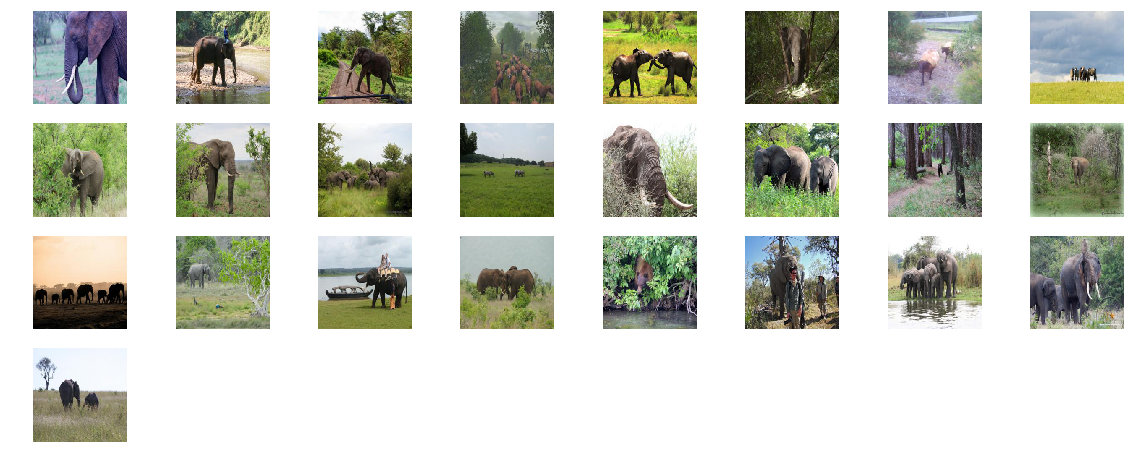

In [7]:
feature_idx = 101

plt.figure(figsize=[20, 10])
def drawImages(images):
    n = len(images)
    n_col = 8
    n_row = n // 6 + 1
    
    for i in range(n):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    
result = []
for i in range(num_train):
    if np.argmax(fc1000_train[i]) == feature_idx:
        result.append(read_image(i))

drawImages(result)

### Text Preprocessing

In [236]:
import re
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import textblob as tb
from textblob import TextBlob as TB
import enchant


stopword_set = set(stopwords.words('english'))
enchant_dict = enchant.Dict("en_US")

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ctc316/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ctc316/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [324]:
# Noun, Verb, Adj, Adv, no Stopwords
def line_process(line):
    res = []
    for w, tag in TB(line).tags:
        if (tag[0] == 'N' or tag[0] == 'V' or tag[0] == 'J' or tag[0] == 'R') \
            and w not in stopword_set :
            res.append(tb.blob.Word(w).singularize())
    return res

#and enchant_dict.check(str(bytes(w))  or tag[0] == 'R'

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def rm_punctuation(word_list):
    """Remove punctuation from list of tokenized words"""
    res = []
    for w in word_list:
        nw = re.sub(r'[^\w\s]', '', w)
        if nw != '':
            res.append(nw)
    return res
            
def stem_words(word_list):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in word_list]

def lemmatize_verbs(word_list):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, pos='v') for w in word_list]

def rm_duplicate(word_list):
    return list(set(word_list))

def doc_preprocess(doc):
    res = []
    for line in doc.split("\n"):
        res.extend(line_process(line.lower()))
    
    res = rm_punctuation(res)
    res = stem_words(res)
    res = lemmatize_verbs(res)
    res = rm_duplicate(res)
    
    print(res)
    return res
    

test_doc = "This is an Apple. Apples are There. I got a banana and 123 bananas." + "\n" + \
           "Running man ran. run run run, he ran!!! Dog Cat Bird" + "\n" + \
           "I  have a red door. he badly had two blue doors.She has 100 dogs"

print(doc_preprocess(test_doc))


['bad', 'banan', 'get', 'dog', 'doorssh', 'run', 'cat', 'blu', 'door', 'man', 'bird', 'appl', 'red']
['bad', 'banan', 'get', 'dog', 'doorssh', 'run', 'cat', 'blu', 'door', 'man', 'bird', 'appl', 'red']



### Train Model fc1000 (X) -> description (wordVec) (Y);  pool5 (X) -> description (wordVec) (Y)

#### Using the word2vec dictionary by gensim

In [ ]:
%%time

word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print("Loaded word vectors successfully!")

#### Parse features to form X matrices and descriptions to form the Y matrices

In [ ]:
%%time

def doc_to_vec(doc, word2vec):
    word_vecs = [word2vec.get_vector(w) for w in doc_preprocess(doc) if w in word2vec.vocab]
    return np.stack(word_vecs).mean(0)

x_dev_train_fc1000 = fc1000_train[split_idx_train]
x_dev_test_fc1000 = fc1000_train[split_idx_test]
x_dev_train_pool5 = pool5_train[split_idx_train]
x_dev_test_pool5 = pool5_train[split_idx_test]
y_dev_train = np.array([doc_to_vec(desc_train[i], word2vec) for i in split_idx_train])
y_dev_test = np.array([doc_to_vec(desc_train[i], word2vec) for i in split_idx_test])

print("x_dev_train_fc1000 shape:", x_dev_train_fc1000.shape)
print("x_dev_test_fc1000 shape:", x_dev_test_fc1000.shape)
print("x_dev_train_pool5 shape:", x_dev_train_pool5.shape)
print("x_dev_test_pool5 shape:", x_dev_test_pool5.shape)
print("y_dev_train shape:", y_dev_train.shape)
print("y_dev_test shape:", y_dev_test.shape)

In [ ]:
%%time

def train_model(x, y):
#     parameters = {"alpha": [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500, 1000.0]}
    parameters = {"alpha": [100, 200, 500, 1000, 2000]}
    reg = GridSearchCV(Ridge(), parameters, cv=10)
    reg.fit(x, y)
    return reg

reg_dev_fc1000 = train_model(x_dev_train_fc1000, y_dev_train)
reg_dev_pool5 = train_model(x_dev_train_pool5, y_dev_train)

print("Trained linear regression model!")
print("Summary of best model:")
print(reg_dev_fc1000.best_estimator_)
print(reg_dev_pool5.best_estimator_)


#### Test performance on development set

In [ ]:
%%time

weights = [0, 1]
y_dev_pred_fc1000 = reg_dev_fc1000.predict(x_dev_test_fc1000)
y_dev_pred_pool5 = reg_dev_pool5.predict(x_dev_test_pool5)
dev_distances = weights[0] * euclidean_distances(y_dev_test, y_dev_pred_fc1000) + \
                weights[1] * euclidean_distances(y_dev_test, y_dev_pred_pool5)

dev_scores = []
dev_pos_list = []
for i in range(num_test):
    pred_dist_idx = list(np.argsort(dev_distances[i]))
    dev_pos = pred_dist_idx.index(i)
    dev_pos_list.append(dev_pos)
    if dev_pos < 20:
        dev_scores.append(1 / (dev_pos + 1))
    else:
        dev_scores.append(0.0)
        
print("Development MAP@20:", np.mean(dev_scores))
print("Mean index of true image", np.mean(dev_pos_list))
print("Median index of true image", np.median(dev_pos_list))

### Predict on test data

In [ ]:
%%time

x_train_fc1000 = np.concatenate([x_dev_train_fc1000, x_dev_test_fc1000])
x_train_pool5 = np.concatenate([x_dev_train_pool5, x_dev_test_pool5])
y_train = np.concatenate([y_dev_train, y_dev_test])

x_test_fc1000 = fc1000_test
x_test_pool5 = pool5_test

y_test = np.array([doc_to_vec(d, word2vec) for d in desc_test])

reg_fc1000 = train_model(x_train_fc1000, y_train)
reg_pool5 = train_model(x_train_pool5, y_train)

print(reg_fc1000.best_estimator_)
print(reg_pool5.best_estimator_)

#### Submission

In [ ]:
y_pred_fc1000 = reg_fc1000.predict(x_test_fc1000)
y_pred_pool5 = reg_pool5.predict(x_test_pool5)
distances = weights[0] * euclidean_distances(y_test, y_pred_fc1000) + \
            weights[1] * euclidean_distances(y_test, y_pred_pool5)


pred_rows = []
for i in range(num_test):
    top_20 = list(np.argsort(distances[i]))[:20]
    row = ["%d.jpg" % i for i in top_20]
    pred_rows.append(" ".join(row))

with open("submission/submission_" + time.strftime('%m%d_%H%M%S') + ".csv", "w") as f:
    f.write("Descritpion_ID,Top_20_Image_IDs\n")
    for i, row in enumerate(pred_rows):
        f.write("%d.txt,%s\n" % (i, row))

print("Output written!")